# Assignment \#4 : Line Broadening

Kaimi Kahihikolo

Due: 25 February 2019

In [1]:
import numpy as np
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
plt.style.use('seaborn')

___
## (1) Natural Broadening

1. Calculate a Lorentz profile for an absorption line corresponding to a transition with level lifetimes $\Delta t = 10^{-8}$s, and frequency $\nu_0$ equivalent to a wavelength of $5000 A^{\circ}$. Make your calculation for an array of 100 frequencies centered at $\nu_0$ (choose the range of frequencies wisely). 
1. Next, calculate and plot the Lorentz profile as a function of wavelength. Choose plot limits that will allow to appreciate the peak and wings of the profile. 
1. Estimate on your plot the FWHM of the profile in $A^{\circ}$. It should agree with $\Gamma /2\pi$ transformed into $A^{\circ}$.

In [2]:
lifetime = 1e-8 *u.s
Gamma = 1./lifetime
nu0 = (const. c / (5000 * u.AA)).to('Hz')

### (1.1)

In [3]:
def lorentz(nus, nu0=nu0):
    global Gamma
    term1 = (4*np.pi**2)*(nus-nu0)**2
    term2 = (Gamma/(2.))**2
    
    return Gamma * 1./(term1 + term2)

In [4]:
nus = np.arange(nu0.value - 1e8, nu0.value + 1e8, 100) * u.Hz
profile = lorentz(nus, nu0)
profile = profile / profile.max()

### (1.2)

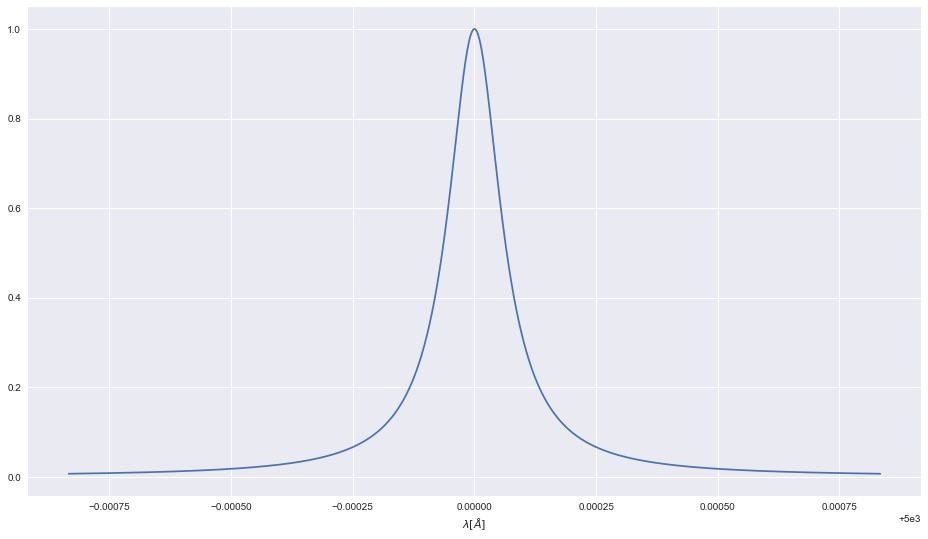

In [5]:
fig = plt.figure(figsize=(16,9))
x = np.sort((const.c / nus).to(u.AA))
plt.plot(x.value, profile)

plt.xlabel('$\lambda [\AA]$')
plt.savefig('lorentz.png', dpi=300, bbox_inches='tight')

### (1.3)

In [6]:
def fwhm(x, y, k=3):
    from scipy.interpolate import splrep, sproot, splev
    """
    Determine full-with-half-maximum of a peaked set of points, x and y. The function
    uses a spline interpolation of order k.
    """

    half_max = np.amax(y)/2.0
    s = splrep(x, y - half_max, k=k)
    roots = sproot(s)
    
    return abs(roots[1] - roots[0])

fwhm_lorentz = (fwhm(x.value, profile.value))*u.AA
print(f"FWHM [from curve] = {(fwhm_lorentz):.3e}")

##Δv = Δλ ·(c / λ^2) -> Δλ = Δv / (c / λ^2)
print(f"Damping Constant [Gamma/2pi] = {(Gamma/(2*np.pi) / (const.c / (5000. *u.AA)**2)).to(u.AA):.3e}")

FWHM [from curve] = 1.327e-04 Angstrom
Damping Constant [Gamma/2pi] = 1.327e-04 Angstrom


which are in agreement.

___
## (2) Doppler Broadening

1. Calculate $V_{th}$ and $\Delta \lambda_D$ for MgII line at 4481 $A^{\circ}$, at a temperature of 10000 K. 

1. Calculate a Guassian profile and plot it. $$\exp\left(-\frac{(\lambda-\lambda_0)^2}{\Delta\lambda_D^2}\right)$$ Calculate the intensity of the Gaussian profile at a wavelength $\lambda = \lambda_0 + \Delta\lambda_D$.

1. Now compare with the Lorentz profile calculated in Section. At what wavelength, measured from λ0, will the Lorentz profile become higher than the Doppler profile? Make a plot showing both profiles (it may be more illustrative to plot the log of the intensity as a function of wavelength)


### (2.1)

The most probable speed, $v_{th}$, can be computed by recalling,

$$v_{th} = \sqrt{\frac{2kT}{m}}$$

And the width of the thermal (doppler) broadening profile can be computed by,

$$\lambda_D^2 = \frac{\lambda_0^2}{c^2} v_{th}^2$$

According to [NIST](https://physics.nist.gov/PhysRefData/Handbook/Tables/magnesiumtable1.htm), MgII has an atomic mass of 23.9850.

In [7]:
MgII_lambda = 4481 *u.AA
T = 10000 *u.K

m_MgII = 278.11394 * u.g / u.mol 
v_th = np.sqrt((2.*const.k_B*T)/(23.9850 * u.u)).to(u.m / u.s)

print(f"v_th = {v_th : .3f}")

lambda_D = np.sqrt(MgII_lambda**2  * v_th**2 / const.c**2).to(u.m)
print(f"Δλ_D = {lambda_D : .3e}")

v_th =  2633.068 m / s
Δλ_D =  3.936e-12 m


### (2.2)

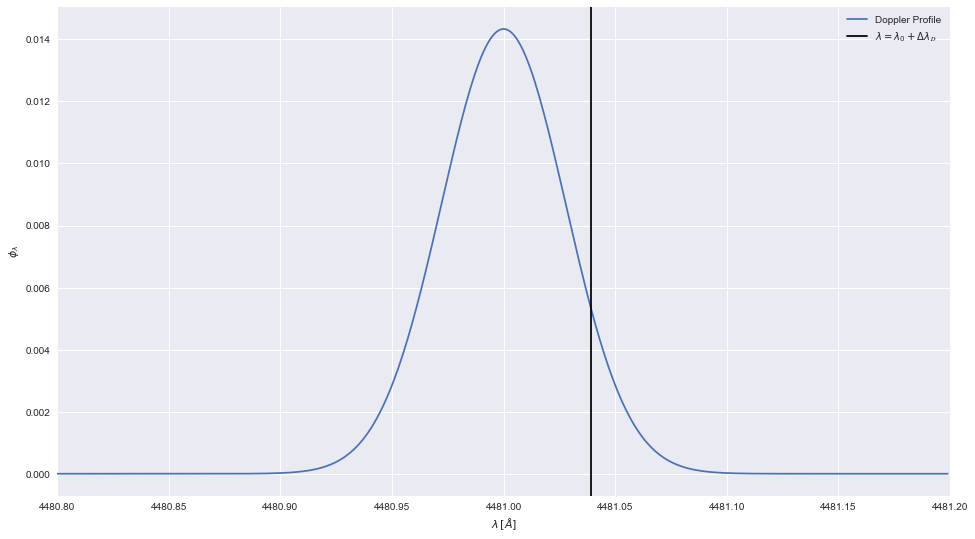

Intensity [𝜆=4481.039 Angstrom] = [0.37457399]


In [8]:
fig = plt.figure(figsize=(16,9))
lambdas = np.arange(4480.8, 4481.2, 0.001) *u.AA
Mg_profile = np.exp(-(lambdas - MgII_lambda)**2 / (lambda_D**2))

plt.plot(lambdas, Mg_profile/np.trapz(Mg_profile), label='Doppler Profile')

temp_line = (MgII_lambda+lambda_D).to(u.AA).round(3)

plt.axvline(x=temp_line.value, color='k', label='$\lambda=\lambda_0+\Delta\lambda_𝐷$')
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel('$\phi_\lambda$')
plt.legend()
plt.xlim(4480.8, 4481.2)
plt.show()

print(f"Intensity [𝜆={temp_line}] =",
      f"{Mg_profile[np.where(abs(lambdas.value - temp_line.value) < 0.0001)]}")

### (2.3)

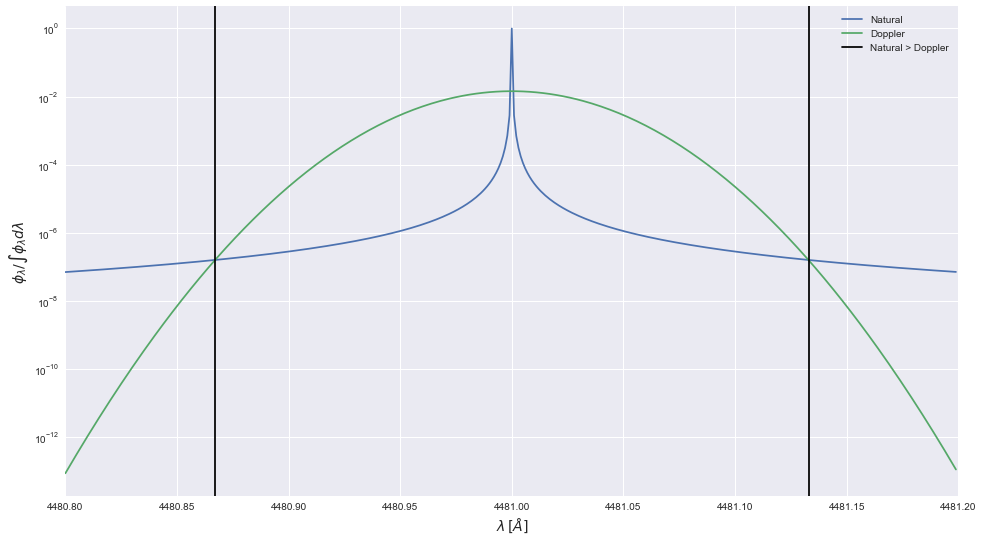

The natural profile is greater than the doppler for  𝜆 < 4480.867 Angstrom or 𝜆 > 4481.133 Angstrom


In [9]:
nu0 = (const. c / (4481. * u.AA)).to('Hz')

nus = const.c / lambdas
natural_profile = lorentz(nus, nu0)
natural_profile = natural_profile / np.trapz(natural_profile)


fig = plt.figure(figsize=(16,9))
plt.plot(lambdas, natural_profile, label='Natural')

doppler_profile = Mg_profile/np.trapz(Mg_profile)

plt.plot(lambdas, doppler_profile, label='Doppler')

_, = np.where(natural_profile > doppler_profile)
idx = np.argmax(np.diff(_) > 1)
plt.axvline(x=lambdas[idx].value, color='k', label='Natural > Doppler')
_ = np.argmax(natural_profile)
idx2 = _ +(_ - idx)
plt.axvline(x=lambdas[idx2].value, color='k')


plt.legend()
plt.xlim(4480.8, 4481.2)
plt.yscale('log')
plt.ylabel(r'$\phi_\lambda/\int \phi_\lambda d\lambda$', size=14)
plt.xlabel('$\lambda \, [\AA]$', size=14)

plt.show()

print(r"The natural profile is greater than the doppler for ",
          f"𝜆 < {lambdas[idx].round(3)} or 𝜆 > {lambdas[idx2].round(3)}")

___
## (3) Rotation

1. Calculate the escape velocities for main sequence stars of spectral types O, B, A, F and G. The stellar parameters may be taken from the Hertzsprung Russell diagrams shown in the first Power-Point, or from any edition of Allen’s Astrophysical Quantities. 
1. Make a table with your input parameters and results. Which stars have the highest escape velocities? 
1. Calculate the maximum rotational broadening (total width of line profile), in $A^{\circ}$, that we can expect to find for a B-type star. Assume a non-Hydrogen spectral line at $5000 A^{\circ}$. Why did I specify that it cannot be a H-line?

### (3.1)
Recall for a spherically symmetric body, the escape velocity $v_e$ is,

$$v_e = \sqrt{\frac{2GM}{r}}$$

Here some stellar parameters for O, B, A, F, and G stars used in the calculation:

In [10]:
stellar_parametes = {
        'O' : {'M' : 64 *u.Msun, 'R' : 16 *u.Rsun},
        'B' : {'M' : 18 *u.Msun, 'R' : 7 *u.Rsun},
        'A' : {'M' : 3.1 *u.Msun, 'R' : 2 *u.Rsun},
        'F' : {'M' : 1.7 *u.Msun, 'R' : 1.4 *u.Rsun},
        'G' : {'M' : 1.1 *u.Msun, 'R' : 1.1 *u.Rsun},
    }

Source: https://people.highline.edu/iglozman/classes/astronotes/hr_diagram.htm

In [11]:
def escape_velocity(params):
    M, r = params
    return np.sqrt(2*const.G * M / r).to(u.km/u.s).round(3)

for i, spectra_type in enumerate(stellar_parametes.keys()):
    stellar_parametes[spectra_type]['v'] = escape_velocity(
                                            stellar_parametes[spectra_type].values())

### (3.2)

In [12]:
import pandas as pd

df = pd.DataFrame(stellar_parametes)
df

,A,B,F,G,O
M,3.1 solMass,18.0 solMass,1.7 solMass,1.1 solMass,64.0 solMass
R,2.0 solRad,7.0 solRad,1.4 solRad,1.1 solRad,16.0 solRad
v,768.999 km / s,990.483 km / s,680.644 km / s,617.675 km / s,1235.349 km / s


As expected, the largest escape velocities are found in the largest stars (ie; O).

### (3.3)
The average rotational velocity of a B type star is about 210 km/s, [source](http://adsabs.harvard.edu/abs/1965Obs....85..166M). Therefore,

In [13]:
rot_width = (5000 *u.AA * 210. * (u.km /u.s) / const.c).to(u.AA)

print(f"Rotational broadening width = {rot_width : .3f}")

Rotational broadening width =  3.502 Angstrom


___